In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torch.nn.utils import clip_grad_norm_
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#prepare data

In [ ]:
data_path = '/kaggle/input/bbbp-csv/BBBP.csv'
class Dataset_BBBP(Dataset):
    def __init__(self, data_path):
        super().__init__()
        self.df = pd.read_csv(data_path, index_col = 'num')
        print('the first 5 data of the dataset without padding')
        print('------------------------------------------------')
        display(self.df.head())
        self.labels = self.df['p_np']
        self.smiles = self.df['smiles']
        self.tokens_freq = {}
        self.token_to_val = {}
        self.max_length = 1
        self.lengths = []

        self._find_max_and_store_length()
        self._calc_tokens_freq_and_vals()

    def __len__(self):
        return len(self.df)

    def plot_distribution(self):
        '''
        plot the distribution of the lengths
        '''
        sns.histplot(data=self.lengths, kde=True)
        plt.show()

    def _find_max_and_store_length(self):
        '''
        this function finds the lengths of all of the data and also find maximum length
        lengths of smiles strings store in the self.lengths variable and maximum length store in self.max_length
        '''
        for string in self.smiles:
            l = Dataset_BBBP.tokenize(string)
            if len(l) > self.max_length :
                self.max_length = len(l)
            self.lengths.append(len(l))

    def _padding(self):
        '''
        add padding to both sides of the smiles string in order to all of the strings have same sizes.
        '''

        for string in self.smiles:
            new_string = string
            l = Dataset_BBBP.tokenize(string)
            if len(l) < self.max_length :
                i = len(l)
                while i < self.max_length:
                    new_string =  '<pad>' + new_string
                    i += 1
                self.smiles.replace(string, new_string, inplace=True)

    @staticmethod
    def combine_dicts(dict1, dict2):
        combined = {}

        for key in dict1:
            combined[key] = dict1[key]

        # Add items from the second dict, combining values where keys match
        for key in dict2:
            if key in combined:
                combined[key] += dict2[key]
            else:
                combined[key] = dict2[key]

        return combined

    @staticmethod
    def tokenize(s):
        '''
        this function tokenize input smiles
        '''
        spec_items_list = ['Cl', 'Br', 'Na', 'Ca', '@@']
        l = re.split('(<pad>)', s)
        for char in spec_items_list:
            temp_list = []
            for i in range(len(l)):
                temp_list += re.split(f'({char})', l[i])
            l = temp_list
        try:
            l.remove('')
        except:
            pass
        tokens = []

        spec_items_list.append('<pad>')
        for item in l:

            if item not in spec_items_list:
                tokens += list(item)
            else:
                tokens.append(item)
        return tokens


    def _calc_tokens_freq_and_vals(self):
        '''
        this function firt call _padding function and then compute tokens frequency and dictionary which is stored in token_to_val dictionary
        '''
        self._padding()
        counter = Dataset_BBBP.combine_dicts(Counter(Dataset_BBBP.tokenize(self.smiles.iloc[0])),
                                             Counter(Dataset_BBBP.tokenize(self.smiles.iloc[1])))
        for i in range(2, len(self.smiles)):
            counter = Dataset_BBBP.combine_dicts(counter,
                                                 Counter(Dataset_BBBP.tokenize(self.smiles.iloc[i])))

        self.tokens_freq = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))
        self.token_to_val = {char: idx for idx, char in enumerate(self.tokens_freq.keys())}

    def get_tokens_freq(self):

        return self.tokens_freq

    def _one_hot(self, x):
        '''
        this function gets x and then tokenize it by calling tokenize
        then compute one-hot encoded of strings
        '''

        num_classes = len(self.token_to_val)
        tokens = Dataset_BBBP.tokenize(x)
       # print(tokens)
        tokens_nums = [self.token_to_val[token] for token in tokens]
        return F.one_hot(torch.tensor(tokens_nums), num_classes)

    def __getitem__(self, idx):
        smiles_enc = self._one_hot(self.smiles.iloc[idx])
        label = torch.tensor([self.labels.iloc[idx]])

        return smiles_enc, label




In [ ]:
dataset = Dataset_BBBP(data_path)

the first 5 data of the dataset without padding
------------------------------------------------


,name,p_np,smiles
num,,,
1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [ ]:
print(f'length of the dataset = {len(dataset)}')


length of the dataset = 2050


**distribution of data lengths**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


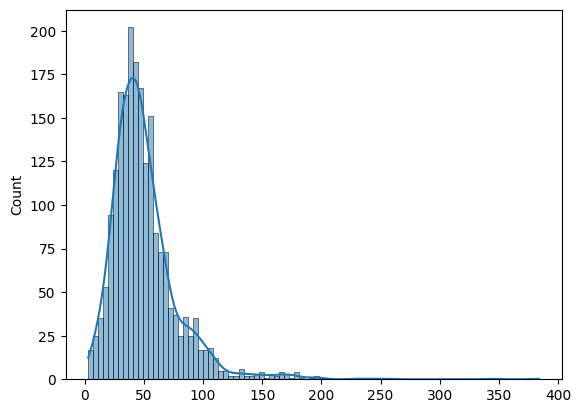

In [ ]:
dataset.plot_distribution()

همانگونه که ملاحظه می گردد طول رشته های دیتاست بالانس نیست. برای همین در کلاس دیتاست به آنها پد اضافه شده است

In [ ]:
l = dataset.get_tokens_freq()
print('frequency of each tokens. note that <pad> is additional token for padding.')
print(l)


frequency of each tokens. note that <pad> is additional token for padding.
{'<pad>': 683620, 'C': 29783, '(': 10491, ')': 10491, '=': 8034, 'c': 6937, 'O': 6208, '1': 4128, 'N': 3933, '[': 3479, ']': 3479, '2': 3370, '3': 2553, 'H': 2392, '@': 1692, '4': 1438, '@@': 1251, 'Cl': 618, 'n': 515, 'S': 510, 'F': 509, '5': 454, '\\': 203, '/': 184, '.': 163, '6': 124, '-': 123, '+': 121, 's': 72, '7': 56, '#': 53, 'Br': 51, 'o': 49, '8': 28, '%': 24, 'Na': 21, '9': 16, 'P': 11, '0': 8, 'I': 6, 'Ca': 1, 'B': 1}


In [ ]:
print('Vocabulary:')
print(dataset.token_to_val)

Vocabulary:
{'<pad>': 0, 'C': 1, '(': 2, ')': 3, '=': 4, 'c': 5, 'O': 6, '1': 7, 'N': 8, '[': 9, ']': 10, '2': 11, '3': 12, 'H': 13, '@': 14, '4': 15, '@@': 16, 'Cl': 17, 'n': 18, 'S': 19, 'F': 20, '5': 21, '\\': 22, '/': 23, '.': 24, '6': 25, '-': 26, '+': 27, 's': 28, '7': 29, '#': 30, 'Br': 31, 'o': 32, '8': 33, '%': 34, 'Na': 35, '9': 36, 'P': 37, '0': 38, 'I': 39, 'Ca': 40, 'B': 41}


In [ ]:
#split dataset
gen = torch.Generator().manual_seed(42)
train_size = 1600
test_size, validation_size = 225, 225
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size], generator=gen)
len(train_dataset), len(test_dataset), len(validation_dataset)

(1600, 225, 225)

In [ ]:
#dataloaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=225, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=225, shuffle=False)

In [ ]:
# Assume 'dataset' is your PyTorch Dataset object
labels = [int(label) for _, label in train_dataset]
train_stat = Counter(labels)
labels = [int(label) for _, label in test_dataset]
test_stat = Counter(labels)
labels = [int(label) for _, label in validation_dataset]
val_stat = Counter(labels)
print(f'train stat={train_stat}, validation stat={val_stat}, test stat={test_stat}')

train stat=Counter({1: 1231, 0: 369}), validation stat=Counter({1: 161, 0: 64}), test stat=Counter({1: 175, 0: 50})


#train FC model

In [ ]:
class FcModel(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super().__init__()

        self.layer1 = nn.Linear(in_features=num_inputs, out_features=num_hiddens)
        self.layer2 = nn.Linear(in_features=num_hiddens, out_features=num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer2(self.relu(self.layer1(x)))

In [ ]:
fc_model = FcModel(42, 500, 1).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=0.001)

In [ ]:
#training loop
import gc
torch.manual_seed(42)

num_epochs = 20
misclassified = []
for epoch in range(num_epochs):
    fc_model.train()
    train_loss = 0.
    train_acc = 0.
    correct_pred = 0.

    for i, (smiles, label) in enumerate(iter(train_loader)):
        smiles_vector= torch.mean(smiles.to(dtype=torch.float32), dim=1)
        smiles_vector, label = smiles_vector.to(device), label.to(device, dtype=torch.float32)

        out = fc_model(smiles_vector)
        preds = torch.round(torch.sigmoid(out))

        correct_pred += (preds == label).float().prod(dim=1).sum()

        loss = criterion(out, label)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del smiles_vector, label, out
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()

    train_acc = correct_pred / len(train_dataset)
    if epoch % 10 == 9:
        print(f"epoch{epoch}: train loss = {train_loss}, train accuracy = {train_acc}")

epoch9: train loss = 14.684061050415039, train accuracy = 0.7918750047683716
epoch19: train loss = 12.330262184143066, train accuracy = 0.8224999904632568


In [ ]:
#validation

val_acc = 0.
val_loss = 0.
val_roc = 0.
fc_model.eval()

for smiles, label in iter(validation_loader):
    smiles_vector = torch.mean(smiles.to(dtype=torch.float32), dim=1)
    smiles_vector, label = smiles_vector.to(device), label.to(device, dtype=torch.float32)

    with torch.inference_mode():
        out = fc_model(smiles_vector)
        preds = torch.round(torch.sigmoid(out))

        loss = criterion(out, label)
        val_loss += loss

        val_acc = accuracy_score(label.cpu().numpy(), preds.cpu().numpy())
        val_roc = roc_auc_score(label.cpu().numpy(), preds.cpu().numpy())

        del smiles_vector, label, out
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()

print(f'validation loss = {val_loss}, validation acc = {val_acc}, Area Under ROC = {val_roc}')


validation loss = 0.4222063720226288, validation acc = 0.8, Area Under ROC = 0.6578513198757764


#train LSTM model

In [ ]:
import torch.nn.init as init

torch.manual_seed(40)
class LstmModel(nn.Module):
    def __init__(self, num_inputs, num_hiddens, lstm_num_layers=1, bidirectional=False):
        super().__init__()
        self.num_layers = lstm_num_layers
        self.num_hiddens = num_hiddens
        self.device = device
        #self.embedding_matrix = nn.Parameter(torch.randn(num_inputs, embedding_dim))

        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=num_hiddens, num_layers=self.num_layers,
                            batch_first=True, bidirectional=bidirectional)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                init.kaiming_normal_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)
        d = 2 if bidirectional else 1
        self.fc1 = nn.Linear(num_hiddens * d, 500)
        self.fc2 = nn.Linear(500, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(num_hiddens * d)

    def forward(self, x):
        #out = torch.matmul(x, self.embedding_matrix)
        out, _ = self.lstm(x)
        out = self.batch_norm(out.transpose(1, 2)).transpose(1, 2)
        out = out[:, -1, :]

        out = self.fc2(self.dropout(self.relu(self.fc1(self.flatten(out)))))

        return out


In [ ]:
lstm_model = LstmModel(42, 40, 1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=.001)


In [ ]:
#training loop
import gc

torch.manual_seed(45)
#threshold = 0.5
num_epochs = 40
misclassified = []
for epoch in range(num_epochs):
    lstm_model.train()
    train_loss = 0.
    train_acc = 0.
    correct_pred = 0

    for i, (smiles, label) in enumerate(iter(train_loader)):

        smiles, label = smiles.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)

        out = lstm_model(smiles)
        #print(f'out = {out}')

        out = torch.sigmoid(out)
        preds = torch.round(out)
        #preds = (torch.sigmoid(out) >= threshold).float()

        correct_pred += (preds == label).float().prod(dim=1).sum()

        #wrong_indices = (preds != label).nonzero(as_tuple=True)[0]

        loss = criterion(out, label)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        #clip_grad_norm_(lstm_model.parameters(), 1.)
        optimizer.step()

        #del smiles, label, out
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()
    print(f'correct pred = {correct_pred}')
    train_acc = correct_pred / len(train_dataset)
    print(f"epoch{epoch}: train loss = {train_loss}, train accuracy = {train_acc}")

correct pred = 1204.0
epoch0: train loss = 16.01415252685547, train accuracy = 0.7524999976158142
correct pred = 1308.0
epoch1: train loss = 12.374842643737793, train accuracy = 0.8174999952316284
correct pred = 1360.0
epoch2: train loss = 10.585294723510742, train accuracy = 0.8499999642372131
correct pred = 1360.0
epoch3: train loss = 10.049910545349121, train accuracy = 0.8499999642372131
correct pred = 1390.0
epoch4: train loss = 9.477068901062012, train accuracy = 0.8687499761581421
correct pred = 1385.0
epoch5: train loss = 9.689456939697266, train accuracy = 0.8656249642372131
correct pred = 1418.0
epoch6: train loss = 8.79857349395752, train accuracy = 0.8862499594688416
correct pred = 1418.0
epoch7: train loss = 8.474372863769531, train accuracy = 0.8862499594688416
correct pred = 1437.0
epoch8: train loss = 7.696201801300049, train accuracy = 0.8981249928474426
correct pred = 1434.0
epoch9: train loss = 7.894761562347412, train accuracy = 0.8962500095367432
correct pred = 144

In [ ]:
#validation

val_acc = 0.
val_loss = 0.
lstm_model.eval()

for smiles, label in iter(validation_loader):
    smiles, label = smiles.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)

    with torch.inference_mode():
        out = lstm_model(smiles)
        out = torch.sigmoid(out)
        preds = torch.round(out)

        loss = criterion(out, label)
        val_loss += loss

        val_acc = accuracy_score(label.cpu().numpy(), preds.cpu().numpy())
        val_roc = roc_auc_score(label.cpu().numpy(), preds.cpu().numpy())
        del smiles, label, out
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()

print(f'validation loss = {val_loss}, validation acc = {val_acc} , Area Under ROC = {val_roc}')

validation loss = 0.4646974802017212, validation acc = 0.8711111111111111 , Area Under ROC = 0.820506599378882


#train BiLSTM Model

In [ ]:
bilstm_model = LstmModel(42, 40, bidirectional=True).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=.001)

In [ ]:
#training loop
import gc

torch.manual_seed(42)

num_epochs = 40

for epoch in range(num_epochs):
    bilstm_model.train()
    train_loss = 0.
    train_acc = 0.
    correct_pred = 0

    for smiles, label in iter(train_loader):

        smiles, label = smiles.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)

        out = bilstm_model(smiles)

        preds = torch.round(torch.sigmoid(out))

        correct_pred += (preds == label).float().prod(dim=1).sum()

        loss = criterion(out, label)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()

        #clip_grad_norm_(bilstm_model.parameters(), 1.)

        optimizer.step()

        del smiles, label, out
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()
    train_acc = correct_pred / len(train_dataset)
    print(f"epoch{epoch}: train loss = {train_loss}, train accuracy = {train_acc}")

epoch0: train loss = 16.5483455657959, train accuracy = 0.7387499809265137
epoch1: train loss = 12.956367492675781, train accuracy = 0.8062499761581421
epoch2: train loss = 11.44437313079834, train accuracy = 0.8343749642372131
epoch3: train loss = 10.42071533203125, train accuracy = 0.8549999594688416
epoch4: train loss = 9.698394775390625, train accuracy = 0.8624999523162842
epoch5: train loss = 9.637019157409668, train accuracy = 0.8700000047683716
epoch6: train loss = 8.625213623046875, train accuracy = 0.8862499594688416
epoch7: train loss = 8.087345123291016, train accuracy = 0.887499988079071
epoch8: train loss = 7.67740535736084, train accuracy = 0.8956249952316284
epoch9: train loss = 7.563499927520752, train accuracy = 0.9012500047683716
epoch10: train loss = 7.2914557456970215, train accuracy = 0.9006249904632568
epoch11: train loss = 6.6486945152282715, train accuracy = 0.9231249690055847
epoch12: train loss = 6.383315563201904, train accuracy = 0.9124999642372131
epoch13: 

In [ ]:
#validation

val_acc = 0.
val_loss = 0.
bilstm_model.eval()

for smiles, label in iter(validation_loader):
    smiles, label = smiles.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)

    with torch.inference_mode():
        out = bilstm_model(smiles)
        preds = torch.round(torch.sigmoid(out))

        loss = criterion(out, label)
        val_loss += loss

        val_acc = accuracy_score(label.cpu().numpy(), preds.cpu().numpy())
        val_roc = roc_auc_score(label.cpu().numpy(), preds.cpu().numpy())
        del smiles, label, out
        if device == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()

print(f'validation loss = {val_loss}, validation acc = {val_acc} , Area Under ROC = {val_roc}')

validation loss = 0.5697422027587891, validation acc = 0.8666666666666667 , Area Under ROC = 0.812694099378882


**Accuracy and AU ROC of both lstm and bilstm models are higher that FC model. lstm and bilstm models have almost same performance and we can see performance of the lstm model is a bit better. but why?**

**As wee saw above length of smiles strings are very imbalanced and we add padding to start of the strings. when we use bi-lstmو it checks the both sides of the strings. one layer that starts processing of strings from end of them, first see real pattern of molecules and then see lots of padding elements(\<pad>\) so for example if real length of data is 7, it sees 384-7=377 padding element so it forgets real molecule pattern. so bilstm does not help to improving performance of the model**

In [ ]:
pad_tensor = torch.Tensor([1] + [0] * (42 - 1))
pad_tensor = pad_tensor.unsqueeze(0)
pad_tensors = pad_tensor.repeat(384, 1)
TestData = []

fc_model.eval()
lstm_model.eval()
bilstm_model.eval()

for smiles, label in iter(test_loader):


    smiles_vector = torch.mean(smiles.to(dtype=torch.float32), dim=1)
    smiles_vector= smiles_vector.to(device)
    smiles, label = smiles.to(device, dtype=torch.float32), label.to(device, dtype=torch.float32)

    with torch.inference_mode():
        out1 = fc_model(smiles_vector)
        out2 = lstm_model(smiles)
        out3 = bilstm_model(smiles)
        preds1 = torch.round(torch.sigmoid(out1))
        preds2 = torch.round(torch.sigmoid(out2))
        preds3 = torch.round(torch.sigmoid(out3))
    pad_tensors = pad_tensors.to(device)
    for i in range(225):

        l = 384 - (smiles[i] == pad_tensors).float().prod(dim=1).sum()
        correct_preds1 = (preds1[i] == label[i]).int()
        correct_preds2 = (preds2[i] == label[i]).int()
        correct_preds3 = (preds3[i] == label[i]).int()

        TestData.append([int(l), int(correct_preds1), int(correct_preds2), int(correct_preds3)])




In [ ]:
# Sorting by Length
TestData = sorted(TestData, key=lambda x: x[0])
TestData

[[5, 1, 1, 1],
 [5, 1, 1, 1],
 [5, 1, 1, 1],
 [7, 1, 1, 1],
 [8, 1, 1, 1],
 [8, 1, 1, 1],
 [8, 1, 1, 1],
 [8, 1, 1, 1],
 [10, 1, 1, 1],
 [12, 1, 1, 1],
 [12, 1, 1, 1],
 [14, 1, 1, 1],
 [16, 1, 1, 1],
 [17, 1, 1, 1],
 [17, 1, 1, 1],
 [18, 1, 1, 1],
 [19, 1, 0, 1],
 [19, 0, 0, 0],
 [20, 0, 0, 0],
 [20, 1, 1, 1],
 [21, 1, 1, 1],
 [21, 1, 1, 1],
 [22, 1, 1, 1],
 [22, 0, 1, 1],
 [22, 1, 1, 1],
 [22, 0, 0, 0],
 [23, 1, 1, 1],
 [23, 1, 1, 1],
 [23, 1, 1, 1],
 [23, 1, 1, 1],
 [24, 1, 1, 1],
 [25, 1, 1, 1],
 [26, 1, 1, 1],
 [26, 0, 0, 0],
 [26, 1, 1, 1],
 [26, 1, 1, 1],
 [26, 1, 1, 1],
 [27, 1, 0, 0],
 [27, 1, 1, 1],
 [27, 0, 0, 0],
 [28, 1, 1, 0],
 [28, 1, 1, 1],
 [28, 1, 1, 1],
 [28, 1, 1, 1],
 [28, 1, 1, 1],
 [29, 1, 1, 1],
 [29, 1, 0, 1],
 [30, 1, 1, 0],
 [30, 1, 1, 1],
 [30, 1, 1, 1],
 [30, 1, 1, 1],
 [30, 1, 1, 1],
 [30, 1, 1, 1],
 [30, 1, 1, 1],
 [30, 1, 1, 1],
 [31, 1, 1, 1],
 [31, 1, 1, 1],
 [31, 1, 1, 1],
 [31, 1, 1, 1],
 [31, 0, 0, 0],
 [31, 1, 1, 1],
 [31, 1, 1, 0],
 [31, 1, 0, 1],


In [ ]:
lengths = list(np.array(TestData)[: ,0])
bins = np.histogram(lengths, bins=10)[1]

# This ensures that max and min values are placed correctly in bins
bins[-1] += 1
bins[0] -= 1
print(f'Bins: {bins}')

TestData_bins = [[], [], [], [], [], [], [], [], [], []]
for i in range(len(TestData)):
    for j in range(len(bins)-1):
        if TestData[i][0] > bins[j] and  TestData[i][0] < bins[j+1]:
            TestData_bins[j].append(TestData[i])



Bins: [  4.  24.  43.  62.  81. 100. 119. 138. 157. 176. 196.]


In [ ]:
bins_lengths = [len(bins) for bins in TestData_bins]
fc_model_correctpreds_num = []
lstm_model_correctpreds_num = []
bilstm_model_correctpreds_num = []
for i in range(len(TestData_bins)):
    s1, s2, s3 = 0, 0, 0
    for j in range(len(TestData_bins[i])):
        s1 += TestData_bins[i][j][1]
        s2 += TestData_bins[i][j][2]
        s3 += TestData_bins[i][j][3]
    fc_model_correctpreds_num.append(s1)
    lstm_model_correctpreds_num.append(s2)
    bilstm_model_correctpreds_num.append(s3)

**This plot shows lstm and bilstm have better performance in longer strings**

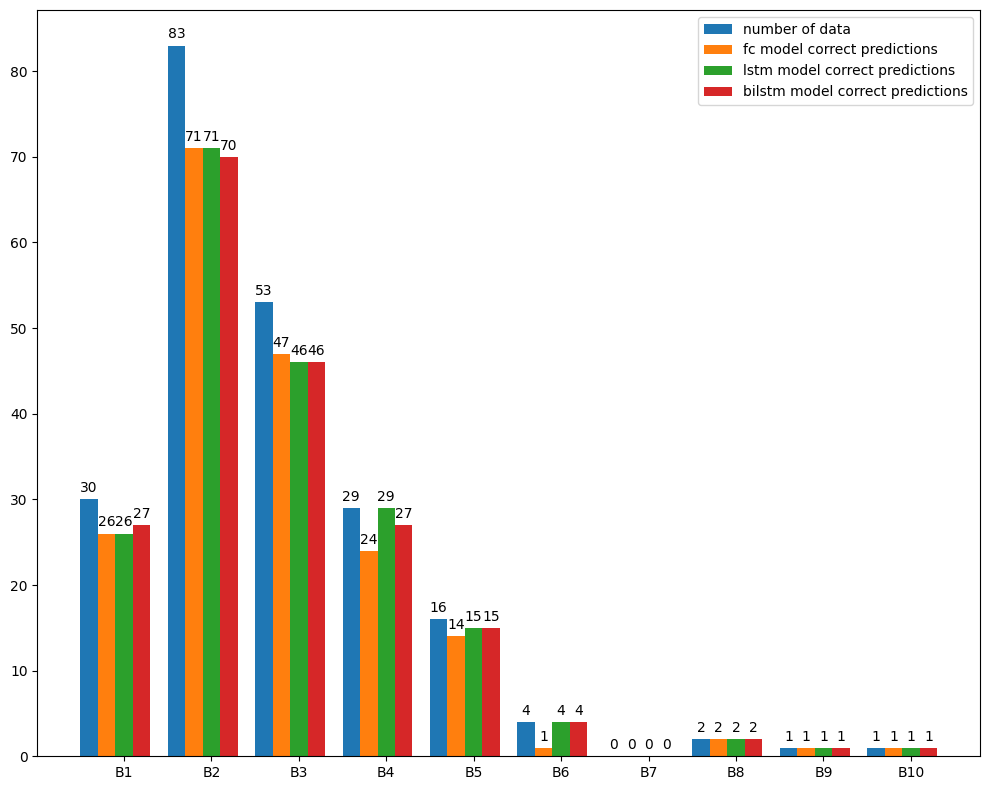

In [ ]:
labels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10']
x = 10 * np.arange(len(labels))  # the label locations
width = 2  # the width of the bars

fig, ax = plt.subplots(figsize = (10, 8))
rects1 = ax.bar(x - 2*width, bins_lengths, width, label='number of data')
rects2 = ax.bar(x - width, fc_model_correctpreds_num, width, label='fc model correct predictions')
rects3 = ax.bar(x, lstm_model_correctpreds_num, width, label='lstm model correct predictions')
rects4 = ax.bar(x + width, bilstm_model_correctpreds_num, width, label='bilstm model correct predictions')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

ax.set_xticks(x, labels)
ax.legend()
fig.tight_layout()

plt.show()